In [1]:
# Import the lib 
import tensorflow as tf
import inspect
import os,sys
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
tf.set_random_seed(0)
np.random.seed(0)

# Youtube Video and Reference
1. https://www.youtube.com/watch?v=fIW8fI2Xb_k
2. https://www.quora.com/In-which-way-exactly-are-Gram-matrices-similar-to-covariance-matrices
3. http://mlwiki.org/index.php/Gram_Matrices
4. https://stats.stackexchange.com/questions/164997/relationship-between-gram-and-covariance-matrices
5. 

In [2]:
# my layers and activation functions
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater_equal(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x):   return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x):   return x
def d_tf_iden(x): return x

class CNN():

    def __init__(self,k,inc,out,stddev=0.05,which_reg=0,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),
        filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.which_reg == 0:   grad = grad
        if self.which_reg == 0.5: grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
        if self.which_reg == 1:   grad = grad + lamda * tf.sign(self.w)
        if self.which_reg == 1.5: grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
        if self.which_reg == 2:   grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
        if self.which_reg == 2.5: grad = grad + lamda * 2.0 * self.w
        if self.which_reg == 3:   grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
        if self.which_reg == 4:   grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w
    
class FNN():

    def __init__(self,inc,outc,act=tf_elu,d_act=d_tf_elu,special_init=False,which_reg=0.0):
      
        self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float32))
        self.b = tf.Variable(tf.zeros        ([outc],dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.m_b,self.v_b = tf.Variable(tf.zeros_like(self.b)),tf.Variable(tf.zeros_like(self.b))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w) + self.b
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient=None,which_reg=0):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad  = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_b= tf.reduce_mean(grad_middle,axis=0)
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        # === Reg ===
        if self.which_reg == 0:
            grad  = grad
            grad_b= grad_b

        if self.which_reg == 0.5:
            grad  = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
            grad_b= grad_b+lamda * (tf.sqrt(tf.abs(self.b))) * (1.0/tf.sqrt(tf.abs(self.b)+ 10e-5)) * tf.sign(self.b)

        if self.which_reg == 1:
            grad = grad   + lamda * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.sign(self.b)

        if self.which_reg == 1.5:
            grad = grad   + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
            grad_b=grad_b + lamda * 1.0/(tf.sqrt(tf.square(self.b) + 10e-5)) * self.b

        if self.which_reg == 2:
            grad = grad  + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
            grad_b=grad_b+ lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.b))+ 10e-5)) * tf.abs(self.b) * tf.sign(self.b)

        if self.which_reg == 2.5:
            grad = grad   + lamda * 2.0 * self.w
            grad_b=grad_b + lamda * 2.0 * self.b

        if self.which_reg == 3:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.b),2) * tf.sign(self.b)

        if self.which_reg == 4:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.b),3) * tf.sign(self.b)

        update_w = []

        # Update the Weight First
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))

        # Update the Bias later
        update_w.append(tf.assign(self.m_b,self.m_b*beta1 + (1-beta1) * (grad_b)   ))
        update_w.append(tf.assign(self.v_b,self.v_b*beta2 + (1-beta2) * (grad_b ** 2)   ))
        m_hat_b = self.m_b / (1-beta1)
        v_hat_b = self.v_b / (1-beta2)
        adam_middle_b = m_hat_b *  learning_rate/(tf.sqrt(v_hat_b) + adam_e)
        update_w.append(tf.assign(self.b,tf.subtract(self.b,adam_middle_b )))

        return grad_pass,update_w    

In [11]:
# Read all of the texture image data
PathDicom =  '../../DataSet/texture/images/'
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".jpg" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

lstFilesDCM= shuffle(lstFilesDCM)
train_data = np.asarray(Image.open(lstFilesDCM[0]).resize((64,64)))[None,:,:,:]
for i in range(1,500):
    temp       = np.asarray(Image.open(lstFilesDCM[i]).resize((64,64)))[None,:,:,:]
    train_data = np.vstack((train_data,temp))
print(train_data.shape)

(500, 64, 64, 3)


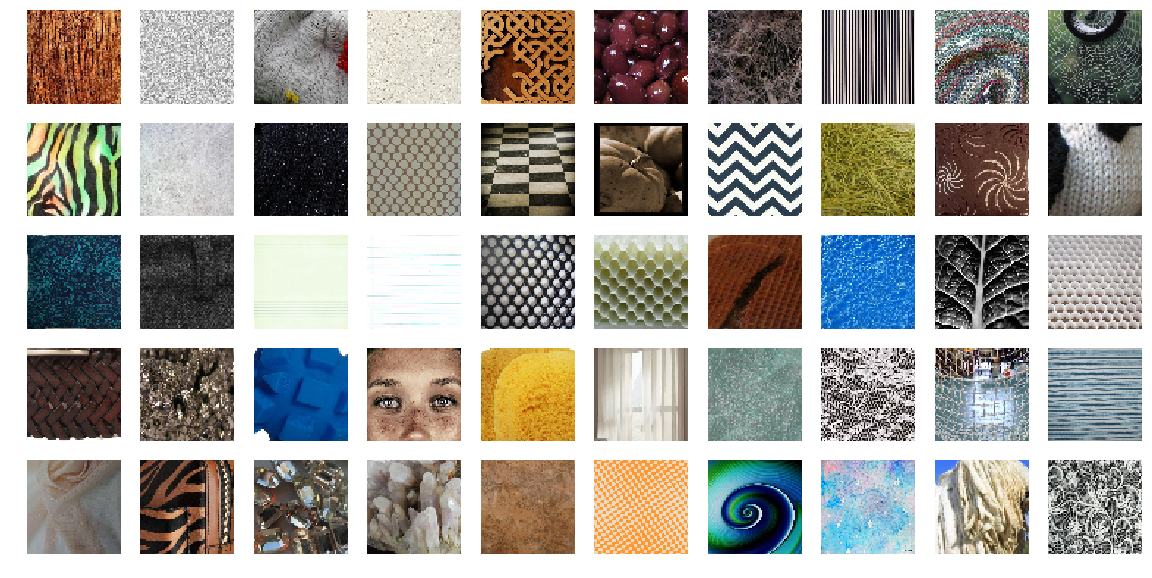

In [4]:
# Show the random images
def show_images(data,columns=10,rows=5):
    fig=plt.figure(figsize=(20, 10))
    columns = columns; rows = rows
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(np.squeeze(data[i-1]))
        plt.grid(False)
        plt.axis('off')
    plt.show()
show_images(shuffle(train_data))

In [5]:
# set the path for vgg 16
vgg16_npy_path = "../../pretrained/vgg16.npy"

In [6]:
# Create the VGG class : https://github.com/machrisaa/tensorflow-vgg/blob/master/test_vgg16.py
VGG_MEAN = [103.939, 116.779, 123.68]
class Vgg16:
    
    def __init__(self, vgg16_npy_path=None):
        
        if vgg16_npy_path is None:
            path = inspect.getfile(Vgg16)
            path = os.path.abspath(os.path.join(path, os.pardir))
            path = os.path.join(path, "vgg16.npy")
            vgg16_npy_path = path
            print(path)

        self.data_dict = np.load(vgg16_npy_path, encoding='latin1').item()
        print("npy file loaded")

    def build(self, rgb):
        """
        load variable from npy to build the VGG
        :param rgb: rgb image [batch, height, width, 3] values scaled [0, 1]
        """

        start_time = time.time()
        print("build model started")
        rgb_scaled = rgb * 255.0

        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=rgb_scaled)
        assert red.get_shape().as_list()[1:]   == [64, 64, 1]
        assert green.get_shape().as_list()[1:] == [64, 64, 1]
        assert blue.get_shape().as_list()[1:]  == [64, 64, 1]
        bgr = tf.concat(axis=3, values=[
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ])
        assert bgr.get_shape().as_list()[1:]   == [64, 64, 3]

        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1   = self.avg_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2   = self.avg_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.pool3   = self.avg_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.pool4   = self.avg_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        self.pool5   = self.avg_pool(self.conv5_3, 'pool5')

#         self.fc6   = self.fc_layer(self.conv5_3, "fc6")
#         assert self.fc6.get_shape().as_list()[1:] == [4096]
#         self.relu6 = tf.nn.relu(self.fc6)

#         self.fc7   = self.fc_layer(self.relu6, "fc7")
#         self.relu7 = tf.nn.relu(self.fc7)

#         self.fc8   = self.fc_layer(self.relu7, "fc8")
#         self.prob  = tf.nn.softmax(self.fc8, name="prob")

#         self.data_dict = None
        print(("build model finished: %ds" % (time.time() - start_time)))

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)
            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')
            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)
            relu = tf.nn.relu(bias)
            return relu

    def fc_layer(self, bottom, name):
        with tf.variable_scope(name):
            shape = bottom.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(bottom, [-1, dim])

            weights = self.get_fc_weight(name)
            biases = self.get_bias(name)

            # Fully connected layer. Note that the '+' operation automatically broadcasts the biases.
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name="weights")

In [7]:
# Load the model / hyper
num_epoch = 100; batch_size = 5; learning_rate = 0.0008
beta1,beta2,adam_e = 0.9,0.999,1e-8
my_vgg_tf  = Vgg16(vgg16_npy_path)

e1 = CNN(3,3,3)
e2 = CNN(3,3,3)
e3 = CNN(3,3,3)
e4 = CNN(3,3,3)
e5 = FNN(8*8*3,2,act=tf_iden,d_act=d_tf_iden)

d1 = FNN(2,8*8*3)
d2 = CNN(3,3,3)
d3 = CNN(3,3,3)
d4 = CNN(3,3,3)
d5 = CNN(3,3,3)

npy file loaded


In [8]:
# create the graph

# ====== Create Gram Matrix for Original Data ======
vgg_input_data  = tf.placeholder(shape=[batch_size,64,64,3],dtype=tf.float32)
my_vgg_tf.build(vgg_input_data);

gt_pool1     = tf.reshape(my_vgg_tf.pool1,[batch_size,-1,64]);  gt_pool1_gram= tf.matmul(tf.transpose(gt_pool1,[0,2,1]),gt_pool1)
gt_pool2     = tf.reshape(my_vgg_tf.pool2,[batch_size,-1,128]); gt_pool2_gram= tf.matmul(tf.transpose(gt_pool2,[0,2,1]),gt_pool2)
gt_pool3     = tf.reshape(my_vgg_tf.pool3,[batch_size,-1,256]); gt_pool3_gram= tf.matmul(tf.transpose(gt_pool3,[0,2,1]),gt_pool3)
gt_pool4     = tf.reshape(my_vgg_tf.pool4,[batch_size,-1,512]); gt_pool4_gram= tf.matmul(tf.transpose(gt_pool4,[0,2,1]),gt_pool4)
gt_pool5     = tf.reshape(my_vgg_tf.pool5,[batch_size,-1,512]); gt_pool5_gram= tf.matmul(tf.transpose(gt_pool5,[0,2,1]),gt_pool5)
# ====== Create Gram Matrix for Original Data ======

# ======== Create input for my data ========
x  = tf.placeholder(shape=[batch_size,64,64,3],dtype=tf.float32)

elayer1 = e1.feedforward(x)
elayer1_pool = tf.nn.max_pool(elayer1,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')
elayer2 = e2.feedforward(elayer1_pool)
elayer2_pool = tf.nn.max_pool(elayer2,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')
elayer3 = e3.feedforward(elayer2_pool)
elayer3_pool = tf.nn.max_pool(elayer3,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')
elayer4 = e4.feedforward(elayer3_pool)

elayer5_input = tf.reshape(elayer4,[batch_size,-1])
elayer5       = e5.feedforward(elayer5_input)
dlayer1       = d1.feedforward(elayer5)
dlayer1_otput = tf.reshape(dlayer1,[batch_size,8,8,3])

dlayer2 = d2.feedforward(dlayer1_otput)
dlayer3_pool  = tf.image.resize_bilinear(dlayer2,[16,16])
dlayer3 = d3.feedforward(dlayer3_pool)
dlayer4_pool  = tf.image.resize_bilinear(dlayer3,[32,32])
dlayer4 = d4.feedforward(dlayer4_pool)
dlayer5_pool  = tf.image.resize_bilinear(dlayer4,[64,64])
dlayer5 = d5.feedforward(dlayer5_pool)
# ======== Create input for my data ========

# ====== Create Gram Matrix for Predict Data ======
my_vgg_tf.build(dlayer5);
pd_pool1     = tf.reshape(my_vgg_tf.pool1,[batch_size,-1,64]);  pd_pool1_gram= tf.matmul(tf.transpose(pd_pool1,[0,2,1]),pd_pool1)
pd_pool2     = tf.reshape(my_vgg_tf.pool2,[batch_size,-1,128]); pd_pool2_gram= tf.matmul(tf.transpose(pd_pool2,[0,2,1]),pd_pool2)
pd_pool3     = tf.reshape(my_vgg_tf.pool3,[batch_size,-1,256]); pd_pool3_gram= tf.matmul(tf.transpose(pd_pool3,[0,2,1]),pd_pool3)
pd_pool4     = tf.reshape(my_vgg_tf.pool4,[batch_size,-1,512]); pd_pool4_gram= tf.matmul(tf.transpose(pd_pool4,[0,2,1]),pd_pool4)
pd_pool5     = tf.reshape(my_vgg_tf.pool5,[batch_size,-1,512]); pd_pool5_gram= tf.matmul(tf.transpose(pd_pool5,[0,2,1]),pd_pool5)
# ====== Create Gram Matrix for Predict Data ======

# ====== Create the Loss Function ======
gram1_loss = tf.reduce_mean(tf.square(pd_pool1_gram-gt_pool1_gram),(1,2))/(4 * 32 **2)
gram2_loss = tf.reduce_mean(tf.square(pd_pool2_gram-gt_pool2_gram),(1,2))/(4 * 16 **2)
gram3_loss = tf.reduce_mean(tf.square(pd_pool3_gram-gt_pool3_gram),(1,2))/(4 *  8 **2)
gram4_loss = tf.reduce_mean(tf.square(pd_pool4_gram-gt_pool4_gram),(1,2))/(4 *  4 **2)
gram5_loss = tf.reduce_mean(tf.square(pd_pool5_gram-gt_pool5_gram),(1,2))/(4 *  2 **2)
total_gram_loss = gram1_loss + gram2_loss + gram3_loss + gram4_loss + gram5_loss
gradient_respect_to_input = tf.gradients(total_gram_loss,dlayer5)[0] * 0.005
# # ====== Create the Loss Function ======

# # ====== Perform Back Propagation =======
dgrad5,dgrad5_up = d5.backprop(gradient_respect_to_input)
dgrad5_pool      = tf.nn.avg_pool(dgrad5,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')
dgrad4,dgrad4_up = d4.backprop(dgrad5_pool)
dgrad4_pool      = tf.nn.avg_pool(dgrad4,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')
dgrad3,dgrad3_up = d3.backprop(dgrad4_pool)
dgrad3_pool      = tf.nn.avg_pool(dgrad3,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')
dgrad2,dgrad2_up = d2.backprop(dgrad3_pool)

dgrad1_input     = tf.reshape(dgrad2,[batch_size,-1])
dgrad1,dgrad1_up = d1.backprop(dgrad1_input)
egrad5,egrad5_up = e5.backprop(dgrad1)
egrad5_reshape   = tf.reshape(egrad5,[batch_size,8,8,3])

egrad4,egrad4_up = e4.backprop(egrad5_reshape)
egrad4_pool      = tf.image.resize_bilinear(egrad4,[16,16])
egrad3,egrad3_up = e3.backprop(egrad4_pool)
egrad3_pool      = tf.image.resize_bilinear(egrad3,[32,32])
egrad2,egrad2_up = e2.backprop(egrad3_pool)
egrad2_pool      = tf.image.resize_bilinear(egrad2,[64,64])
egrad1,egrad1_up = e1.backprop(egrad2_pool)
grad_update      = dgrad5_up + dgrad4_up + dgrad3_up + dgrad2_up + dgrad1_up + \
                   egrad5_up + egrad4_up + egrad3_up + egrad2_up + egrad1_up 

build model started
build model finished: 0s
build model started
build model finished: 0s


In [13]:
print(train_data.min(),train_data.max(),train_data.mean(),train_data.std())
train_data_norm = (train_data - train_data.min((1,2),keepdims=True))/(train_data.max((1,2),keepdims=True)-train_data.min((1,2),keepdims=True)+1e-5)
print(train_data_norm.min(),train_data_norm.max(),train_data_norm.mean(),train_data_norm.std())

0 255 118.646841796875 69.46770551386945
0.0 0.9999999607843153 0.4649280667430663 0.2801473399455072


In [ ]:
# create interactive sess 
# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())

for iter in range(num_epoch*10):
    
    for current_data_index in range(0,len(train_data),batch_size):
        current_data = train_data_norm[current_data_index:current_data_index+batch_size,:,:,:]
        sess_results = sess.run([total_gram_loss,gradient_respect_to_input,grad_update],
                       feed_dict={vgg_input_data:current_data,x:current_data})
        sys.stdout.write('\rCurrent Iter: ' + str(iter) + ' Current Loss: ' + str(sess_results[0].mean()))
        sys.stdout.flush()

    train_data = shuffle(train_data)
    if iter % 20: print('\n================')

Current Iter: 1 Current Loss: 1126015400000.00
Current Iter: 2 Current Loss: 1114196700000.00
Current Iter: 3 Current Loss: 1127955800000.00
Current Iter: 4 Current Loss: 1106780600000.00
Current Iter: 5 Current Loss: 1091192000000.00
Current Iter: 6 Current Loss: 1085045500000.00
Current Iter: 7 Current Loss: 1080822330000.00
Current Iter: 8 Current Loss: 1077723660000.00
Current Iter: 9 Current Loss: 1074772600000.00
Current Iter: 10 Current Loss: 1071040300000.00
Current Iter: 11 Current Loss: 1066372960000.00
Current Iter: 12 Current Loss: 1061356960000.00
Current Iter: 13 Current Loss: 1056052150000.00
Current Iter: 14 Current Loss: 1051541240000.00
Current Iter: 15 Current Loss: 1047861700000.00
Current Iter: 16 Current Loss: 1044591600000.00
Current Iter: 17 Current Loss: 1041258000000.00
Current Iter: 18 Current Loss: 1038834600000.00
Current Iter: 19 Current Loss: 1037209440000.00
Current Iter: 21 Current Loss: 1033590800000.00
Current Iter: 22 Current Loss: 1032735000000.00
C

In [26]:
# get random output 
test_x = tf.placeholder(shape=[batch_size,64,64,3],dtype=tf.float32)

elayer1 = e1.feedforward(test_x)
elayer1_pool = tf.nn.max_pool(elayer1,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')
elayer2 = e2.feedforward(elayer1_pool)
elayer2_pool = tf.nn.max_pool(elayer2,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')
elayer3 = e3.feedforward(elayer2_pool)
elayer3_pool = tf.nn.max_pool(elayer3,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')
elayer4 = e4.feedforward(elayer3_pool)

elayer5_input = tf.reshape(elayer4,[batch_size,-1])
elayer5       = e5.feedforward(elayer5_input)

sess_results = sess.run(elayer5,feed_dict={test_x:train_data[:batch_size]})
print(sess_results)
print(sess_results.shape)
real_samepl = sess_results.copy()

[[269.5941    50.84661 ]
 [262.66507   51.10507 ]
 [304.4603    51.883625]
 [216.96284   41.735783]
 [257.89243   45.509064]]
(5, 2)


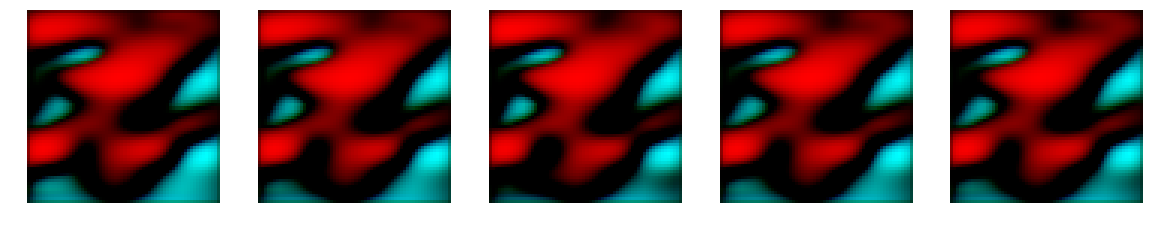

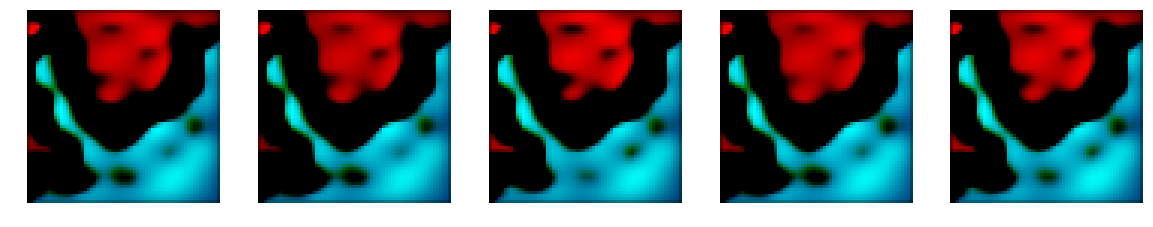

In [31]:
# 
generate_x    = tf.placeholder(shape=[batch_size,2],dtype=tf.float32)

dlayer1       = d1.feedforward(generate_x)
dlayer1_otput = tf.reshape(dlayer1,[batch_size,8,8,3])

dlayer2 = d2.feedforward(dlayer1_otput)
dlayer3_pool  = tf.image.resize_bilinear(dlayer2,[16,16])
dlayer3 = d3.feedforward(dlayer3_pool)
dlayer4_pool  = tf.image.resize_bilinear(dlayer3,[32,32])
dlayer4 = d4.feedforward(dlayer4_pool)
dlayer5_pool  = tf.image.resize_bilinear(dlayer4,[64,64])
dlayer5 = d5.feedforward(dlayer5_pool)

sess_results = sess.run(dlayer5,feed_dict={generate_x:np.random.uniform(size=(batch_size,2)) })
sess_results = (sess_results-sess_results.min((1,2),keepdims=True))/(sess_results.max((1,2),keepdims=True)-sess_results.min((1,2),keepdims=True)+1e-8)
show_images(sess_results,columns=5,rows=1)

sess_results = sess.run(dlayer5,feed_dict={generate_x:real_samepl })
sess_results = (sess_results-sess_results.min((1,2),keepdims=True))/(sess_results.max((1,2),keepdims=True)-sess_results.min((1,2),keepdims=True)+1e-8)
show_images(sess_results,columns=5,rows=1)

In [ ]:
# create interactive sess 
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

all_gradients = sess.run(gradient_input,
     feed_dict={vgg_input_data:train_data[:batch_size]})[0]

for currnet_index in range(batch_size,len(train_data),batch_size):
    current_data  = train_data[currnet_index:currnet_index+batch_size]
    sess_results  = sess.run(gradient_input,feed_dict={vgg_input_data:current_data})[0]
    all_gradients = np.vstack((all_gradients,sess_results))
print('Done Final Gradient Shape: ',all_gradients.shape)

In [35]:
# show the gradient min max mean std 
print(all_gradients.min())
print(all_gradients.max())
print(all_gradients.mean())
print(all_gradients.std())
all_gradients_norm = (all_gradients-all_gradients.min((1,2))[:,None,None,:] )/\
                     (all_gradients.max((1,2))-all_gradients.min((1,2))+1e-10)[:,None,None,:]
print(all_gradients_norm.min())
print(all_gradients_norm.max())
print(all_gradients_norm.mean())
print(all_gradients_norm.std())

-1486.5891
1755.1183
0.3960656
71.154274
0.0
1.0
0.49524608
0.11419233


# Reference
1. machrisaa/tensorflow-vgg. (2018). GitHub. Retrieved 24 October 2018, from https://github.com/machrisaa/tensorflow-vgg/blob/master/test_vgg16.py
2. tf.gradients | TensorFlow. (2018). TensorFlow. Retrieved 24 October 2018, from https://www.tensorflow.org/api_docs/python/tf/gradients
3. TensorFlow, H. (2018). How tf.gradients work in TensorFlow. Stack Overflow. Retrieved 24 October 2018, from https://stackoverflow.com/questions/41822308/how-tf-gradients-work-in-tensorflow
4. DICOM in Python: Importing medical image data into NumPy with PyDICOM and VTK. (2014). PyScience. Retrieved 24 October 2018, from https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/
5. plots, H. (2018). Hiding axis text in matplotlib plots. Stack Overflow. Retrieved 24 October 2018, from https://stackoverflow.com/questions/2176424/hiding-axis-text-in-matplotlib-plots
6. tensorflow, S. (2018). Swap tensor axes in tensorflow. Stack Overflow. Retrieved 24 October 2018, from https://stackoverflow.com/questions/38212205/swap-tensor-axes-in-tensorflow
7. machrisaa/tensorflow-vgg. (2018). GitHub. Retrieved 24 October 2018, from https://github.com/machrisaa/tensorflow-vgg/blob/master/test_vgg16.py
8. Backend - Keras Documentation. (2018). Keras.io. Retrieved 24 October 2018, from https://keras.io/backend/
9. flatten, I. (2018). Issue with Keras backend flatten. Stack Overflow. Retrieved 24 October 2018, from https://stackoverflow.com/questions/47480076/issue-with-keras-backend-flatten
10. Backend - Keras 1.2.2 Documentation. (2018). Faroit.github.io. Retrieved 24 October 2018, from https://faroit.github.io/keras-docs/1.2.2/backend/
11. 